In [1]:
# =============================================================================
#  ECUACIÓN DE CALOR 1D CON ALGORITMO GENÉTICO (DEAP) - VERSIÓN CORREGIDA
#  Integrantes: 
#   Luis Pablo López Iracheta 
#   Diego Mares Rodríguez
#   Francisco Marín Castillo
#  Fecha: 28 de oct de 2025
#  
#  du/dt - d2u/dx2 = 0
#  u(0,t) = u(1,t) = 0
#  u(x,0) = 1/5 sin(3πx)
#  0 < t < inf , 0 < x < 1
# =============================================================================

In [2]:
import operator, math, random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, gp, tools, algorithms
import math

In [3]:

# Funciones seguras 
def seguro_div(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1.0
def seguro_sin(x):
    try:
        return math.sin(x)
    except:
        return 0.0
def seguro_cos(x):
    try:
        return math.cos(x)
    except:
        return 0.0

def seguro_exp(x):
    try:
        return math.exp(x) if abs(x) < 10 else (1e6 if x > 0 else -1e6)
    except:
        return 0.0

pset = gp.PrimitiveSet("MAIN", 2) 

pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addTerminal(np.pi, name="pi")
#Funciones trigonométricas
pset.addPrimitive(seguro_sin, 1)
pset.addPrimitive(seguro_cos, 1)
pset.addPrimitive(seguro_div, 2)

pset.addEphemeralConstant("rand101", lambda: random.uniform(-3,3))
pset.renameArguments(ARG0='x')  # Variable espacial
pset.renameArguments(ARG1='t')  # Variable temporal

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # minimo
creator.create("Individuo", gp.PrimitiveTree, fitness=creator.FitnessMin) # Individuo basado en árboles primitivos

d:\anaconda3\envs\ds_venv\Lib\site-packages\deap\gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


Iniciadores

In [4]:
# Configuramos la caja de herramientas
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5) # Profundidad mínima y máxima del árbol inicial
toolbox.register("individual", tools.initIterate, creator.Individuo, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [5]:
# Función objetivo

# Creamo sumplejas mallas donde evaluar las soluciones y sus derivadas
x_vals = np.linspace(0, 1, 25) 
t_vals = np.linspace(0, 1, 25) 
X, T = np.meshgrid(x_vals, t_vals) # Malla 2D

def evaluate_AG(individuo):
    func = toolbox.compile(expr=individuo)

    # Matriz para almacenar soluciones evaluadas
    Nt = len(t_vals)
    Nx = len(x_vals)
    U = np.zeros((Nt, Nx)) # Solución en malla (t,x)
    
    # Evaluar la función
    for i, t in enumerate(t_vals):
        for j, x in enumerate(x_vals):
            try:
                val = func(x, t)
                U[i, j] = val if np.isfinite(val) else 1e6
            except Exception:
                U[i, j] = 1e6
    
    # Derivadas
    dt = t_vals[1] - t_vals[0] # paso en t
    dx = x_vals[1] - x_vals[0] # paso en x
    
    Ux = np.gradient(U, dx, axis=1) # Primera derivada espacial
    Uxx = np.gradient(Ux, dx, axis=1)  # Segunda derivada espacial

    Ut = np.gradient(U, dt, axis=0) # Primera derivada temporal
    
    # Residual de la PDE: d_u/d_t - d_u/d-xx = 0
    residual = Ut - Uxx
    residual_error_cud_medio = np.mean(residual**2)
    
    # Condiciones de frontera, muy penadas para que si o si no se cumplan
    condicion_izquierda = np.mean(U[:, 0]**2) * 1000  
    condicion_derecha = np.mean(U[:, -1]**2) * 1000

    # Condición inicial - EL COMPONENTE MÁS IMPORTANTE
    U0 = U[0, :]
    condicion_inicial = (1.0/5.0) * np.sin(3*np.pi*x_vals)
    condicion_inicial_error_cud_medio = np.mean((U0 - condicion_inicial)**2) * 5000  
    
    # Penalización por soluciones constantes, 
    std_x = np.std(U, axis=1)
    media_estandar = np.mean(std_x)
    constancia_penalizacion = 500 / (media_estandar + 1e-6) if media_estandar < 0.01 else 0

    # Recompensa por estructura correcta
    arbol_generado = str(individuo)
    structure_bonus = 0
    if 'sin' in arbol_generado and 'pi' in arbol_generado:
        structure_bonus -= 10  # Recompensa grande
    
    fitness = (
        residual_error_cud_medio * 5.0 +
        condicion_inicial_error_cud_medio +
        condicion_izquierda + condicion_derecha +
        constancia_penalizacion +
        structure_bonus
    )

    # retorna tupla (porque DEAP espera tuplas)
    return (fitness,)


In [6]:
toolbox.register("evaluate", evaluate_AG) # Evaluador de individuos en la población
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=7)

# Limitar la altura de los individuos
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10))




In [7]:
poblacion = toolbox.population(n=300)
hof = tools.HallOfFame(5)  # guardamos los 5 mejores individuos

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

# Generaciones
generaciones = 200
p_cruza = 0.7
p_muta = 0.3


pop, log = algorithms.eaSimple(poblacion, toolbox, p_cruza, p_muta, generaciones, stats=stats, halloffame=hof)





C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_14648\2910118322.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right
C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_14648\2910118322.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right
<string>:1: RuntimeWarning: invalid value encountered in scalar multiply
<string>:1: RuntimeWarning: invalid value encountered in scalar subtract


gen	nevals	min    
0  	300   	153.798
1  	255   	85.0028
2  	237   	83.0928
3  	235   	81.6536
4  	242   	81.6536
5  	231   	78.594 
6  	251   	78.594 
7  	226   	78.594 
8  	221   	78.1503
9  	229   	77.9322
10 	232   	77.5703
11 	241   	77.5703
12 	224   	77.3714
13 	238   	76.0185
14 	239   	76.0185
15 	252   	76.0185
16 	243   	76.0185
17 	247   	76.0185
18 	254   	76.0185
19 	235   	76.0185
20 	219   	75.9299
21 	239   	75.4592
22 	246   	74.9532
23 	238   	74.9321
24 	220   	71.0942
25 	231   	67.6059
26 	230   	67.6059
27 	217   	66.4552
28 	248   	62.8973
29 	235   	66.4552
30 	236   	66.4552
31 	231   	66.4552
32 	242   	64.9396
33 	232   	64.9396
34 	247   	64.9396
35 	259   	64.7923
36 	227   	64.7923
37 	229   	64.3646
38 	238   	64.3646


<string>:1: RuntimeWarning: invalid value encountered in scalar add


39 	238   	63.4913
40 	242   	63.4913
41 	248   	63.4913
42 	235   	63.4913
43 	217   	63.4913
44 	248   	62.9637
45 	226   	62.9637
46 	248   	62.9637
47 	247   	61.7786
48 	240   	61.7786
49 	229   	61.7786
50 	228   	61.7527
51 	254   	61.7153
52 	217   	60.8914
53 	234   	60.8914
54 	241   	60.8914
55 	229   	60.8914
56 	234   	60.8914
57 	241   	60.5215
58 	246   	59.7057
59 	239   	59.7057
60 	235   	59.7057
61 	247   	59.6107
62 	234   	59.6107
63 	245   	59.635 
64 	232   	59.635 
65 	239   	59.635 
66 	245   	58.6688
67 	240   	58.6688
68 	244   	58.6688
69 	249   	58.6688
70 	233   	58.6688
71 	239   	58.6688
72 	257   	58.4805
73 	260   	58.2459
74 	249   	58.2459
75 	236   	58.1655
76 	238   	57.5961
77 	243   	55.9381
78 	236   	55.9381
79 	233   	55.4908
80 	234   	54.7675
81 	253   	53.2841
82 	232   	51.3639
83 	235   	46.7143
84 	242   	46.6632
85 	237   	44.2227
86 	247   	42.4165
87 	237   	42.4165
88 	249   	42.0747
89 	233   	39.6058
90 	241   	34.0371
91 	247   	3

In [8]:
print("Mejor individuo:", hof[0])
print(f"longitud: {len(hof[0])}, altura: {hof[0].height}")

Mejor individuo: mul(neg(sub(seguro_sin(seguro_div(seguro_sin(seguro_sin(mul(2.67679081511515, seguro_sin(t)))), sub(sub(seguro_sin(t), sub(-1.6706970277159423, t)), x))), seguro_div(add(seguro_div(x, pi), seguro_sin(neg(sub(add(-1.8447156178487782, t), seguro_cos(-1.8232622880623404))))), 2.953533149162422))), sub(seguro_cos(seguro_cos(seguro_cos(mul(seguro_sin(sub(mul(x, pi), 2.67679081511515)), mul(seguro_sin(seguro_sin(seguro_sin(x))), sub(seguro_sin(seguro_sin(t)), pi)))))), seguro_cos(add(seguro_div(seguro_cos(mul(seguro_sin(sub(mul(-1.8447156178487782, x), seguro_cos(t))), mul(sub(mul(x, pi), 2.67679081511515), pi))), pi), sub(seguro_sin(neg(add(seguro_div(2.67679081511515, pi), 0.3319293136074304))), sub(-1.6706970277159423, neg(sub(mul(pi, seguro_sin(t)), sub(sub(t, t), seguro_sin(t))))))))))
longitud: 96, altura: 10


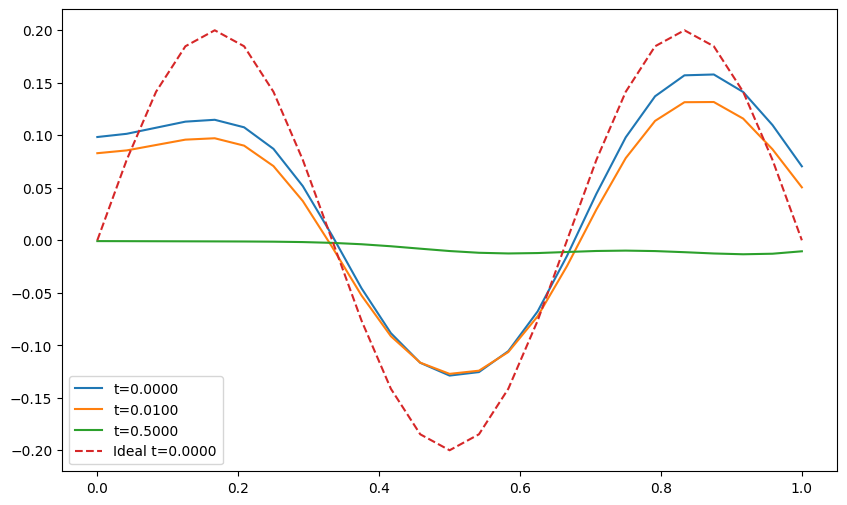

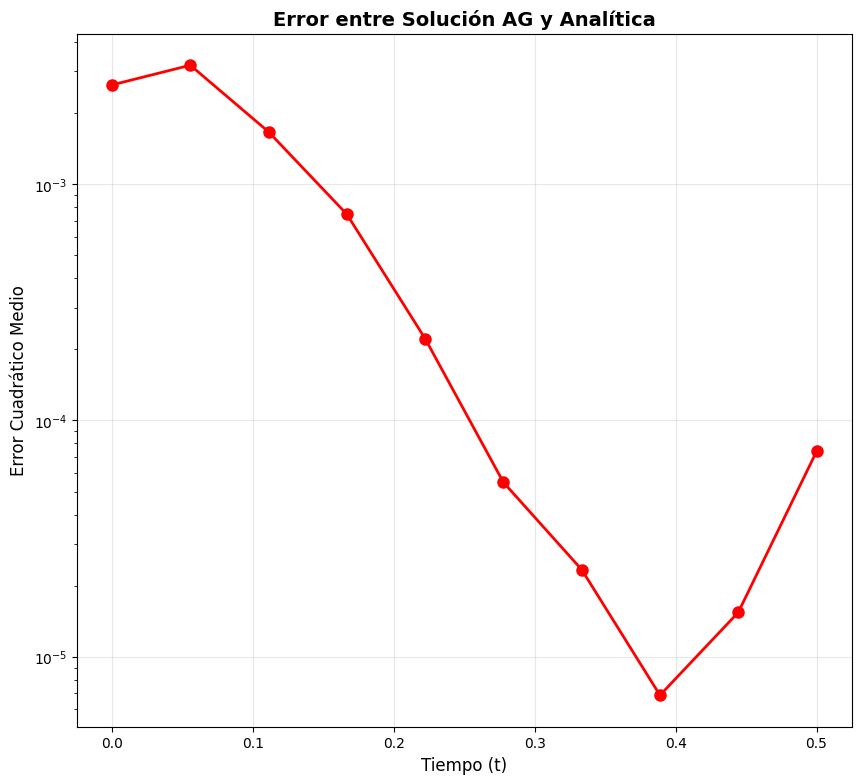

Error cuadrático medio por tiempo:
t = 0.00: MSE = 0.002632
t = 0.06: MSE = 0.003189
t = 0.11: MSE = 0.001666
t = 0.17: MSE = 0.000746
t = 0.22: MSE = 0.000222
t = 0.28: MSE = 0.000055
t = 0.33: MSE = 0.000023
t = 0.39: MSE = 0.000007
t = 0.44: MSE = 0.000015
t = 0.50: MSE = 0.000074


In [9]:
# Grafica en distintos tiempos
ideal = lambda x, t: (1/5)*np.sin(3*np.pi*x)
best = toolbox.compile(expr=hof[0])
plt.figure(figsize=(10, 6))
for t_plot in [0.0, 0.01, 0.5]:
    U_plot = np.array([best(x, t_plot) for x in x_vals])
    plt.plot(x_vals, U_plot, label=f't={t_plot:.4f}')
# Grfica original ideal
for t_plot in [0.0]:
    U_plot = ideal(x_vals, t_plot)
    plt.plot(x_vals, U_plot, linestyle='dashed', label=f'Ideal t={t_plot:.4f}')

plt.legend()
plt.show()
# Graficar en distintos tiempos con mejoras visuales
ideal = lambda x, t: (1/5)*np.sin(3*np.pi*x)*np.exp(-(3*np.pi)**2 * t)
best = toolbox.compile(expr=hof[0])

times = np.linspace(0, 0.5, 10)


#Error cuadrático medio por tiempo
mse_values = []
for t_plot in times:
    ecuacion_ag = np.array([best(x, t_plot) for x in x_vals])
    ecuacion_analitica = ideal(x_vals, t_plot)
    mse = np.mean((ecuacion_ag - ecuacion_analitica)**2)
    mse_values.append(mse)

# Gráfico de error
plt.figure(figsize=(10, 9))
plt.plot(times, mse_values, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Tiempo (t)', fontsize=12)
plt.ylabel('Error Cuadrático Medio', fontsize=12)
plt.title('Error entre Solución AG y Analítica', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Escala logarítmica para mejor visualización
plt.show()

print("Error cuadrático medio por tiempo:")
for t, mse in zip(times, mse_values):
    print(f"t = {t:.2f}: MSE = {mse:.6f}")

In [10]:
# ****************Segunda opción**********************
poblacion = toolbox.population(n=200)
hof1 = tools.HallOfFame(5)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

generaciones = 300
p_cruza = 0.7
p_muta = 0.3

mu = 100        # número de individuos seleccionados para reproducirse
lambda_ = 300   # número de descendientes generados por generación
pop, log = algorithms.eaMuPlusLambda(poblacion, toolbox, mu=mu, lambda_=lambda_, cxpb=p_cruza, mutpb=p_muta, ngen=generaciones, stats=stats, halloffame=hof1, verbose=True)
print("Mejor individuo:", hof1[0])
print(f"longitud: {len(hof1[0])}, altura: {hof1[0].height}")


C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_14648\2910118322.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return left / right
C:\Users\LUIS PC\AppData\Local\Temp\ipykernel_14648\2910118322.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return left / right


gen	nevals	min   
0  	200   	89.567
1  	300   	87.7435
2  	300   	86.4993
3  	300   	86.4993
4  	300   	82.075 
5  	300   	81.9059
6  	300   	78.7653
7  	300   	78.7653
8  	300   	72.5406
9  	300   	73.7794
10 	300   	72.1233
11 	300   	68.8202
12 	300   	64.8657
13 	300   	60.8741
14 	300   	53.0863
15 	300   	53.0863
16 	300   	53.0863
17 	300   	49.8015
18 	300   	49.8015
19 	300   	49.8015
20 	300   	45.2298
21 	300   	43.9469
22 	300   	43.9469
23 	300   	42.3275
24 	300   	42.1034
25 	300   	36.3408
26 	300   	36.3408
27 	300   	36.0659
28 	300   	36.0659
29 	300   	33.5265
30 	300   	32.0123
31 	300   	32.0123
32 	300   	32.0123
33 	300   	31.1728
34 	300   	29.4875
35 	300   	29.4875
36 	300   	28.4471
37 	300   	28.4471
38 	300   	28.4471
39 	300   	27.7563
40 	300   	27.7563
41 	300   	27.7563
42 	300   	27.7563
43 	300   	27.7563
44 	300   	26.7867
45 	300   	26.7867
46 	300   	26.7867
47 	300   	26.7867
48 	300   	26.7867
49 	300   	26.7867
50 	300   	23.0495
51 	300   	23.

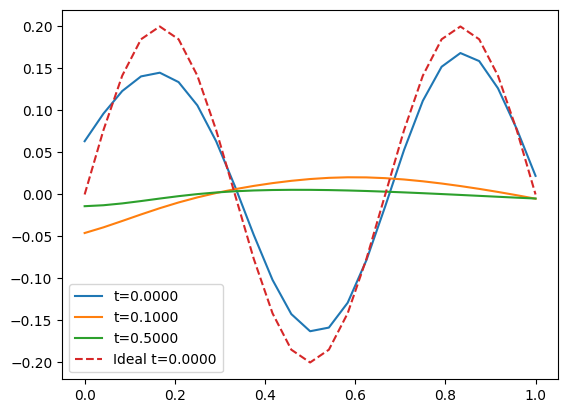

In [11]:
# Grafica en distintos tiempos´
ideal = lambda x, t: (1/5)*np.sin(3*np.pi*x)
best = toolbox.compile(expr=hof1[0])
for t_plot in [0.0, 0.1, 0.5]:
    U_plot = np.array([best(x, t_plot) for x in x_vals])
    plt.plot(x_vals, U_plot, label=f't={t_plot:.4f}')
# Grfica original ideal
for t_plot in [0.0]:
    U_plot = ideal(x_vals, t_plot)
    plt.plot(x_vals, U_plot, linestyle='dashed', label=f'Ideal t={t_plot:.4f}')

plt.legend()
plt.show()